In [75]:
from importlib import reload
import model_functions
reload(model_functions)
from model_functions import fit_linear_model, plot_ground_heigth
import os
import pandas as pd

# 1. Visualize preprocessed flight data

In [77]:
data_dir = "test_data"
flight_id = '0b3f3902-2c04-4625-8576-3bb963e3d709'

parquet_path = os.path.join('..', 'data_process', data_dir, f"{flight_id}.parquet")

df = pd.read_parquet(parquet_path)

#df.info()
print(df.head())

                                               117182271   156875280   \
TimeStamp                        FrameCounter                           
2024-02-14 12:47:29.886827+00:00 0               5.415954       False   
2024-02-14 12:47:29.910267+00:00 1               5.415954       False   
2024-02-14 12:47:32.473459+00:00 2               5.415953       False   
2024-02-14 12:47:32.495396+00:00 3               5.415953       False   
2024-02-14 12:47:32.527699+00:00 4               5.415953       False   

                                               381802901   513685691   \
TimeStamp                        FrameCounter                           
2024-02-14 12:47:29.886827+00:00 0                    1.0  510.103186   
2024-02-14 12:47:29.910267+00:00 1                    1.0  510.103186   
2024-02-14 12:47:32.473459+00:00 2                    1.0  510.183071   
2024-02-14 12:47:32.495396+00:00 3                    1.0  510.183071   
2024-02-14 12:47:32.527699+00:00 4                

In [78]:
print(df.columns)
print(df.index)

Index([ 117182271,  156875280,  381802901,  513685691,  614270119,  637219977,
        638103778,  677695791,  683679735,  705547489,  731865654,  738096043,
        754202368,  786775081,  853651284,  855504072,  943710121, 1049384201,
       1049691088, 1089322549, 1269872157, 1289350632, 1308053202, 1324901455,
       1359970420, 1450782446, 1464341275, 1464691036, 1501357761, 1553784294,
       1556708778, 1666704728, 1796138214, 1847367549, 1879505128, 1895873384,
       1909389254, 1984892607, 2074986628, 2142867155, 2275361864, 2338387453,
       2370500633, 2400822283, 2457184866, 2496586604, 2498379844, 2524343919,
       2545498036, 2546226082, 2590494337, 2663217327, 2700477795, 2705846059,
       2716830861, 2769157819, 2876656444, 2936255604, 2942017749, 2979223644,
       3063191758, 3066527403, 3207956524, 3296928681, 3298276793, 3327788219,
       3335916359, 3355805873, 3358452658, 3410338846, 3502630583, 3590140009,
       3599019297, 3599416138, 3659998070, 368776601

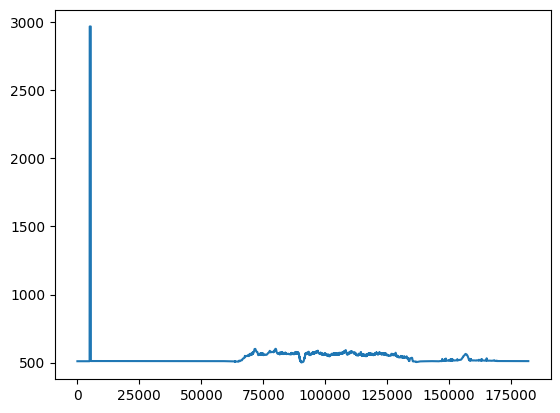

In [79]:
plot_ground_heigth(df)

# 2. Add Label to data

In [ ]:
#TODO add foreach timestamp in range of csv the expected label at the end
# apply time-series modifications
# define a linear model
# fit lasso
# remove unneeded values as a result of fitting a lasso model
# k-fold